run
Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


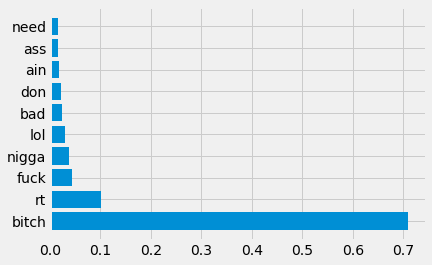

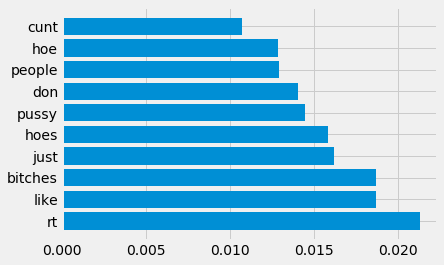

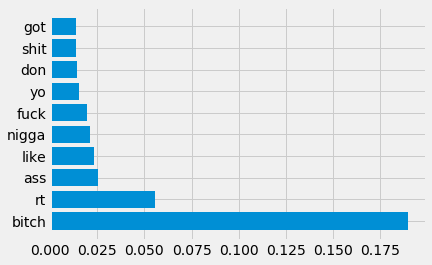

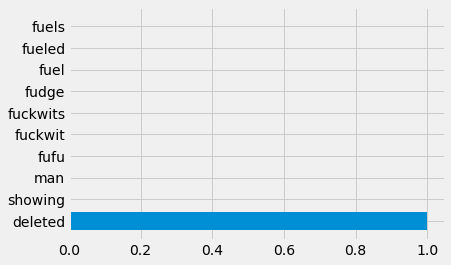

In [64]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

import nltk
import string
import html
import csv

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                                 max_features = 20000)

# email module has some useful functions
import os, sys, email,re
 
    
def htmlConvert(data):
    asciiData = data.copy()
    for i in range(0, len(data)): 
        x = data[i]
        x = html.unescape(x)
        x = re.sub(r"http\S+", "", x)
        x = re.sub("[0-9]", "", x)
        asciiData[i] = x
    return asciiData

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []

    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        score = df['score']
        featureNames = df['features']
        y_pos = np.arange(len(featureNames))
        
        plt.barh(y_pos, score)
        # Create names on the y-axis
        plt.yticks(y_pos, featureNames)
        plt.show()

        dfs.append(df)
        

    return dfs

def formatRedditData(pathname):
    comments = []
    rate = []
    with open(pathname, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            lines = row['text'].splitlines()
            for i in range(len(lines)): 
                x = lines[i]
                x = html.unescape(x)
                x = re.sub(r"http\S+", "", x)
                comments.append(x)
    d = {'comments': comments}
    formatted = pd.DataFrame(data=d)
    return formatted 

def formatStormFrontData(pathname):
    comments = []
    for filename in os.listdir(pathname):
        sample = open(pathname + '/' + filename, 'r')
        text = sample.read()
        comments.append(text)
    d = {'comments': comments}
    formatted = pd.DataFrame(data=d)
    return formatted

def determineClusters(Y_sklearn):  
    number_clusters = range(1, 7)

    kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]

    score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]

    plt.plot(number_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Method')
    plt.show()

        
def runClustering():  
    print("run")
    df = pd.read_csv('hatespeechdata.csv')
    reddit = formatRedditData('reddit.csv')
    stormfront = formatStormFrontData('hate-speech-dataset-master/sampled_train')
    twitter = df['tweet']
    redditData = reddit['comments']
    stormfrontData = stormfront['comments']
    redditFormat = htmlConvert(redditData)
    stormFormat = htmlConvert(twitter)
    tweetFormat = htmlConvert(stormfrontData)
    
    r = pd.DataFrame(redditFormat).to_numpy()
    s = pd.DataFrame(stormFormat).to_numpy()
    t = pd.DataFrame(tweetFormat).to_numpy()
    
    r = r.flatten()
    s = s.flatten()
    t = t.flatten()
    
    allData = np.concatenate((r,s,t))
    pandaData = {'comments': allData}
    finalData = pd.DataFrame(data=pandaData)
    data = finalData['comments']
    
    tf_idf = tf_idf_vectorizor.fit_transform(data)
    tf_idf_norm = normalize(tf_idf)
    tf_idf_array = tf_idf_norm.toarray()
    
    sklearn_pca = PCA(n_components = 2)
    Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
#     determineClusters(Y_sklearn)
    
    test_e = Kmeans(4, 1, 600)
    fitted = test_e.fit_kmeans(Y_sklearn)
    predicted_values = test_e.predict(Y_sklearn)

#     plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

    centers = fitted.centroids
#     plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);
    
    dfs = get_top_features_cluster(tf_idf_array, predicted_values, 10)
    
    

runClustering()
#fetch means of clusters, look at characteristics of clusters